# Facial keypoints Detection
출처: Kaggle [링크](https://www.kaggle.com/c/facial-keypoints-detection)

얼굴 이미지 dataset으로 얼굴의 keypoints를 예측해보았다.

## 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
train = pd.read_csv("data/facial_keypoints/training.zip")
test = pd.read_csv("data/facial_keypoints/test.zip")

In [3]:
train.shape, test.shape

((7049, 31), (1783, 2))

In [4]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

None

In [5]:
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


None

In [6]:
train["Image"] # 데이터가 object type으로 들어있음

0       238 236 237 238 240 240 239 241 241 243 240 23...
1       219 215 204 196 204 211 212 200 180 168 178 19...
2       144 142 159 180 188 188 184 180 167 132 84 59 ...
3       193 192 193 194 194 194 193 192 168 111 50 12 ...
4       147 148 160 196 215 214 216 217 219 220 206 18...
                              ...                        
7044    71 74 85 105 116 128 139 150 170 187 201 209 2...
7045    60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046    74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047    254 254 254 254 254 238 193 145 121 118 119 10...
7048    53 62 67 76 86 91 97 105 105 106 107 108 112 1...
Name: Image, Length: 7049, dtype: object

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [8]:
train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

* object type의 이미지 column을 numpy array로 변환

In [9]:
def pixel_to_image(pixel_vector):
    if type(pixel_vector) == str:
        pixel_vector = pixel_vector.split()
    ndim = int(np.sqrt(len(pixel_vector)))
    return np.array(pixel_vector, dtype = float).reshape(ndim, ndim, 1)

* keypoints에 null이 섞여 있는 데이터들은 제외

In [10]:
x_train_raw = np.array([pixel_to_image(row["Image"]) for i, row in train.dropna(axis = 0).iterrows()])
x_test_raw = np.array([pixel_to_image(row["Image"]) for i, row in test.iterrows()])

In [11]:
x_train_raw.shape, x_test_raw.shape

((2140, 96, 96, 1), (1783, 96, 96, 1))

In [12]:
y_train_raw = train.dropna(axis = 0).drop(columns = "Image").reset_index(drop = True)
y_test = test.drop(columns = "Image")

* 랜덤하게 추출한 이미지 확인

In [13]:
def check_n_img(img, n = 1, ncols = 1, figsize = (12, 20), keypoints = [None], cmap = "gray"):
    nrows = int(np.ceil(n/ncols))
    plt.figure(figsize = figsize)
    samples = np.random.choice(range(len(img)), n, replace = False)
    for idx in range(len(samples)):
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(img[samples[idx]], cmap = cmap)
        plt.title(f'{samples[idx]}')
        if all(keypoints):
            coords = keypoints.loc[samples[idx]]
            for i in range(0, len(coords)-1, 2):
                plt.plot(coords[i], coords[i+1], 'bx')
        plt.axis('off')

* train 데이터 w/ keypoints

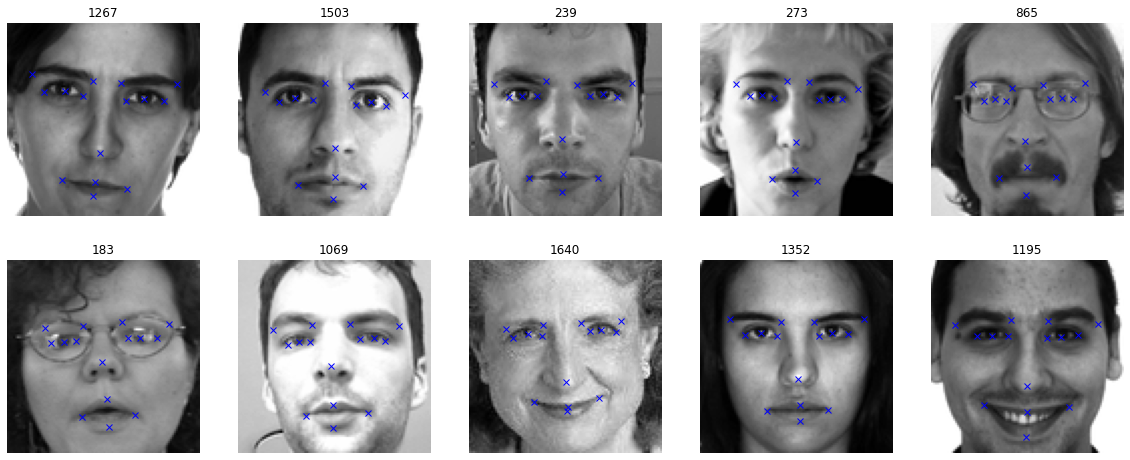

In [14]:
check_n_img(x_train_raw, n = 10, ncols = 5, figsize = (20, 8), keypoints =  y_train_raw)

* train 데이터 w/o keypoints

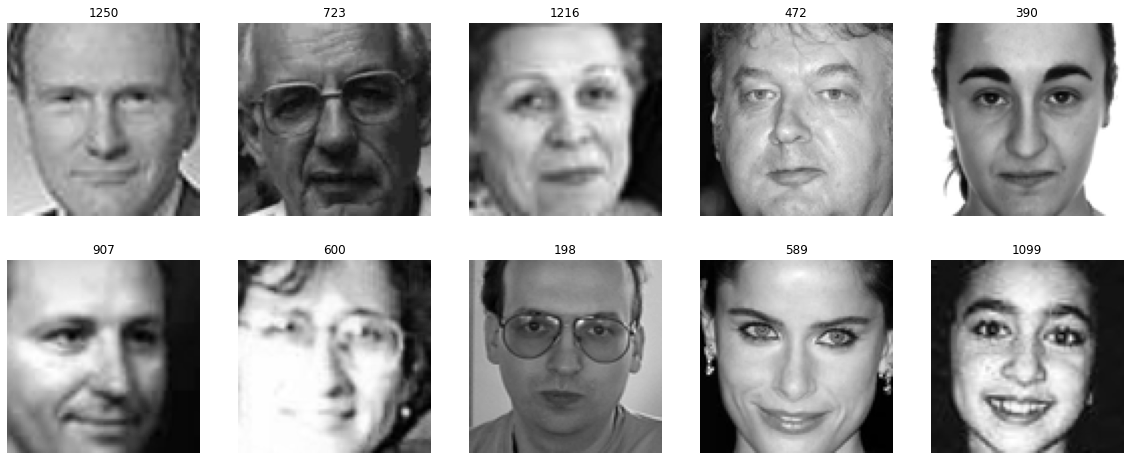

In [15]:
check_n_img(x_test_raw, n = 10, ncols = 5, figsize = (20, 8))

## Image rescale

In [38]:
y_train = y_train_raw

In [39]:
x_train = x_train_raw/255.0
x_test = x_test_raw/255.0

## model 생성
* random contrast, crop 활용한 data aumentation 추가

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.layers import RandomCrop, RandomContrast, GaussianNoise, Normalization


data_augmentation = Sequential([
    RandomContrast(0.3, 0.7),
#     GaussianNoise(0.2),
    Normalization()
])
data_augmentation


model = Sequential()

model.add(data_augmentation)

## convolution layers
model.add(Conv2D(filters = 32, kernel_size = 3, strides = 2, activation = 'relu', padding = "same", input_shape =x_train[0].shape))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = 3, strides = 2, activation = 'relu', padding = "same"))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

## fully-connected layers
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(y_train.shape[1]))

In [130]:
# model.summary()

In [131]:
model.compile(optimizer = 'nadam', loss = "mse", metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [132]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [133]:
history = model.fit(x_train, y_train,
                    epochs = 1000,
                    batch_size = 8,
                    validation_split = 0.2,
                    callbacks = [early_stop], verbose = 1)

Epoch 1/1000
214/214 [==============================] - 2s 5ms/step - loss: 277.7763 - root_mean_squared_error: 16.6666 - val_loss: 1050.1382 - val_root_mean_squared_error: 32.4058
Epoch 2/1000
214/214 [==============================] - 1s 5ms/step - loss: 19.8303 - root_mean_squared_error: 4.4531 - val_loss: 353.0988 - val_root_mean_squared_error: 18.7909
Epoch 3/1000
214/214 [==============================] - 1s 5ms/step - loss: 16.0171 - root_mean_squared_error: 4.0021 - val_loss: 60.0154 - val_root_mean_squared_error: 7.7470
Epoch 4/1000
214/214 [==============================] - 1s 4ms/step - loss: 12.8104 - root_mean_squared_error: 3.5792 - val_loss: 17.0431 - val_root_mean_squared_error: 4.1283
Epoch 5/1000
214/214 [==============================] - 1s 4ms/step - loss: 12.0176 - root_mean_squared_error: 3.4666 - val_loss: 16.2728 - val_root_mean_squared_error: 4.0340
Epoch 6/1000
214/214 [==============================] - 1s 4ms/step - loss: 11.0651 - root_mean_squared_error: 3.

Epoch 94/1000
214/214 [==============================] - 1s 5ms/step - loss: 4.9441 - root_mean_squared_error: 2.2235 - val_loss: 8.6417 - val_root_mean_squared_error: 2.9397
Epoch 95/1000
214/214 [==============================] - 1s 5ms/step - loss: 5.0924 - root_mean_squared_error: 2.2566 - val_loss: 10.3653 - val_root_mean_squared_error: 3.2195
Epoch 96/1000
214/214 [==============================] - 1s 5ms/step - loss: 4.9568 - root_mean_squared_error: 2.2264 - val_loss: 10.1535 - val_root_mean_squared_error: 3.1865
Epoch 97/1000
214/214 [==============================] - 1s 5ms/step - loss: 4.8140 - root_mean_squared_error: 2.1941 - val_loss: 9.5627 - val_root_mean_squared_error: 3.0924
Epoch 98/1000
214/214 [==============================] - 1s 5ms/step - loss: 4.9078 - root_mean_squared_error: 2.2154 - val_loss: 9.8987 - val_root_mean_squared_error: 3.1462
Epoch 99/1000
214/214 [==============================] - 1s 5ms/step - loss: 4.9877 - root_mean_squared_error: 2.2333 - val

214/214 [==============================] - 1s 5ms/step - loss: 4.3675 - root_mean_squared_error: 2.0899 - val_loss: 10.1007 - val_root_mean_squared_error: 3.1782
Epoch 187/1000
214/214 [==============================] - 1s 5ms/step - loss: 4.1204 - root_mean_squared_error: 2.0299 - val_loss: 9.1995 - val_root_mean_squared_error: 3.0331
Epoch 188/1000
214/214 [==============================] - 1s 5ms/step - loss: 4.2533 - root_mean_squared_error: 2.0623 - val_loss: 9.3135 - val_root_mean_squared_error: 3.0518
Epoch 189/1000
214/214 [==============================] - 1s 5ms/step - loss: 4.2013 - root_mean_squared_error: 2.0497 - val_loss: 10.0803 - val_root_mean_squared_error: 3.1750
Epoch 190/1000
214/214 [==============================] - 1s 5ms/step - loss: 4.3625 - root_mean_squared_error: 2.0887 - val_loss: 9.2463 - val_root_mean_squared_error: 3.0408
Epoch 191/1000
214/214 [==============================] - 1s 5ms/step - loss: 4.2037 - root_mean_squared_error: 2.0503 - val_loss: 7.

214/214 [==============================] - 1s 5ms/step - loss: 3.7032 - root_mean_squared_error: 1.9244 - val_loss: 9.6542 - val_root_mean_squared_error: 3.1071
Epoch 279/1000
214/214 [==============================] - 1s 5ms/step - loss: 3.7843 - root_mean_squared_error: 1.9453 - val_loss: 9.4562 - val_root_mean_squared_error: 3.0751
Epoch 280/1000
214/214 [==============================] - 1s 5ms/step - loss: 3.7596 - root_mean_squared_error: 1.9390 - val_loss: 8.7103 - val_root_mean_squared_error: 2.9513
Epoch 281/1000
214/214 [==============================] - 1s 5ms/step - loss: 3.7358 - root_mean_squared_error: 1.9328 - val_loss: 9.4138 - val_root_mean_squared_error: 3.0682
Epoch 282/1000
214/214 [==============================] - 1s 5ms/step - loss: 3.7979 - root_mean_squared_error: 1.9488 - val_loss: 7.7645 - val_root_mean_squared_error: 2.7865
Epoch 283/1000
214/214 [==============================] - 1s 5ms/step - loss: 3.7447 - root_mean_squared_error: 1.9351 - val_loss: 8.95

In [134]:
df_hist = pd.DataFrame(history.history)

<AxesSubplot:>

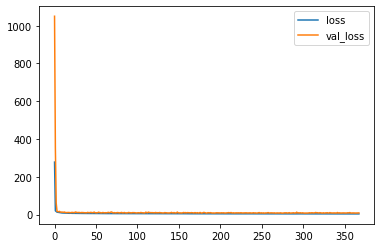

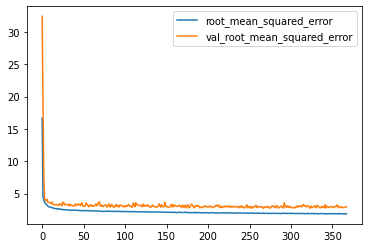

In [135]:
df_hist[["loss", "val_loss"]].plot()
df_hist[["root_mean_squared_error", "val_root_mean_squared_error"]].plot()

In [136]:
_, rmse = model.evaluate(x_valid, y_valid)

7/7 [==============================] - 0s 2ms/step - loss: 15.3019 - root_mean_squared_error: 3.9118


In [137]:
y_predict = model.predict(x_test)

In [138]:
prediction = pd.DataFrame(y_predict, columns = y_train.columns.tolist())
prediction

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,65.242844,36.864182,29.315525,36.661087,59.213554,37.493389,71.661652,37.853340,35.422615,37.413437,...,49.044777,53.307552,62.406933,75.127579,32.066574,75.390694,47.279736,68.814194,47.483528,84.404953
1,66.612030,36.293423,27.727314,37.397297,60.142422,37.291203,73.408043,36.755993,34.370750,37.707813,...,48.400242,57.238209,64.135033,75.053848,33.425259,76.085197,48.600567,71.186134,48.851185,85.677490
2,64.843071,35.678112,30.701210,37.497932,58.971806,36.735985,70.401207,36.223152,36.443279,38.085384,...,49.640308,55.848621,62.478512,72.902679,35.937405,74.097229,49.113705,69.301888,49.515640,82.723663
3,64.246880,38.779987,29.653076,39.393295,57.900269,39.653900,71.264076,39.719101,35.833721,39.760071,...,46.552032,51.669193,62.585270,76.594604,32.248814,77.073341,46.486599,69.570915,46.796944,83.383011
4,67.121056,36.518337,26.886993,37.679970,61.129723,37.104862,73.405617,37.440407,33.791660,37.377193,...,48.949413,51.842304,63.454193,77.405762,34.569107,77.842354,48.804329,69.945435,49.154461,86.956589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,63.247055,37.131660,28.923946,38.135567,56.598236,38.042721,70.297081,37.430267,35.995773,38.288784,...,50.990330,55.253613,61.036667,70.989548,32.339771,72.134003,48.747684,70.027397,48.363903,74.492126
1779,62.975590,34.780289,28.756176,37.822243,56.882130,36.146690,70.254387,34.856426,35.157207,38.055996,...,45.600018,57.637569,63.489113,70.406921,34.062950,72.488060,47.838169,69.522278,48.482132,77.863342
1780,66.943108,37.305088,29.318863,35.954407,59.750229,37.943668,73.734848,38.181438,36.196037,36.774651,...,46.117130,58.186138,58.805782,78.378342,32.580101,77.067719,45.481628,74.346016,45.325031,84.012039
1781,63.278618,35.801262,27.921944,36.424667,56.135571,36.615170,70.470978,36.668377,34.716221,37.020657,...,42.559093,55.305664,59.525543,72.314339,30.154442,71.980133,43.635490,69.750420,43.804905,75.862442


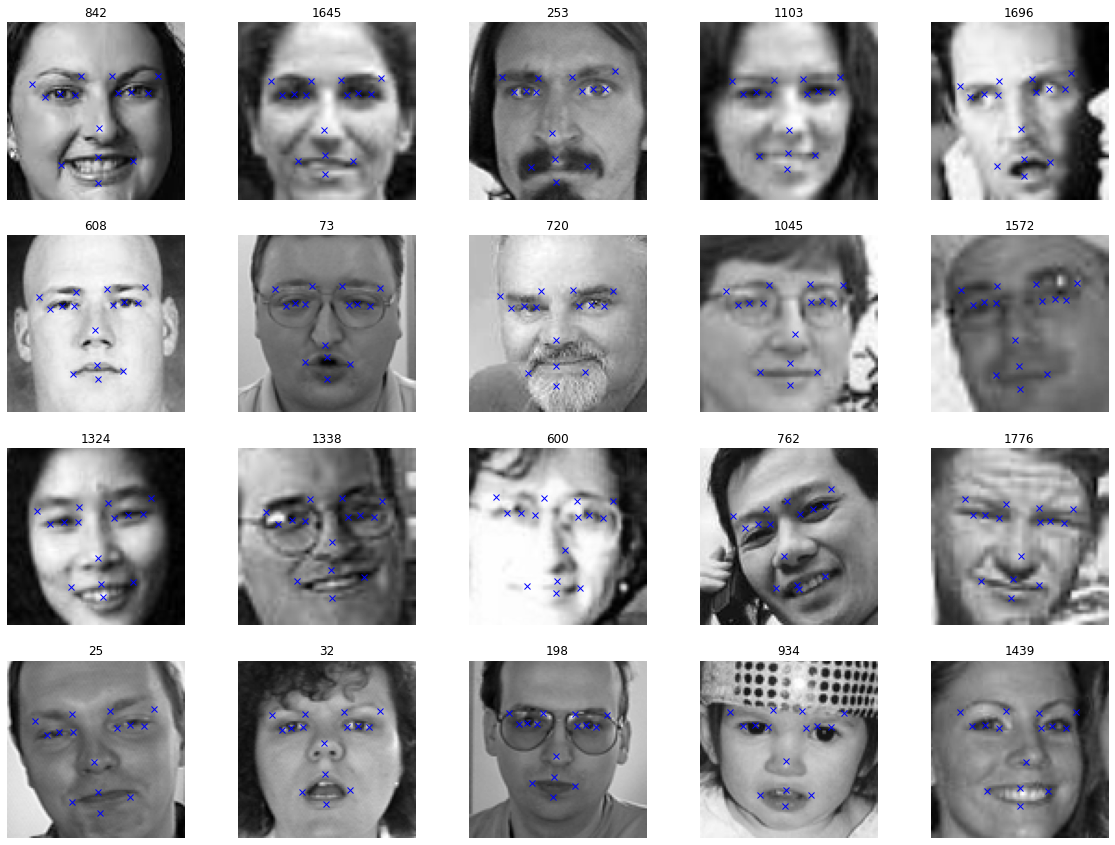

In [139]:
check_n_img(x_test, n = 20, ncols = 5, figsize = (20, 15), keypoints =  prediction)

In [140]:
id_lut = pd.read_csv("data/facial_keypoints/IdLookupTable.csv")
id_lut

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
...,...,...,...,...
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN


In [141]:
prediction["ImageId"] = prediction.index + 1
prediction = prediction.melt(id_vars="ImageId").sort_values(["ImageId", "variable"]).reset_index(drop = True)
prediction = prediction.rename(columns = {"variable" : "FeatureName", "value" : "Location"})
prediction

,ImageId,FeatureName,Location
0,1,left_eye_center_x,65.242844
1,1,left_eye_center_y,36.864182
2,1,left_eye_inner_corner_x,59.213554
3,1,left_eye_inner_corner_y,37.493389
4,1,left_eye_outer_corner_x,71.661652
...,...,...,...
53485,1783,right_eye_outer_corner_y,38.650959
53486,1783,right_eyebrow_inner_end_x,38.764168
53487,1783,right_eyebrow_inner_end_y,31.167322
53488,1783,right_eyebrow_outer_end_x,16.255484


In [142]:
df_submit= pd.read_csv("data/facial_keypoints/SampleSubmission.csv")


df_submit

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27119,27120,0
27120,27121,0
27121,27122,0
27122,27123,0


In [143]:
df_submit = pd.merge(id_lut.drop(columns = "Location"), prediction, how = "left", on = ["ImageId", "FeatureName"])[["RowId", "Location"]]
df_submit

,RowId,Location
0,1,65.242844
1,2,36.864182
2,3,29.315525
3,4,36.661087
4,5,59.213554
...,...,...
27119,27120,37.834766
27120,27121,46.435291
27121,27122,58.189404
27122,27123,45.389999


In [144]:
df_submit.to_csv(f"data/facial_keypoints/submit_{rmse:.5f}.csv", index = False)

In [145]:
pd.read_csv(f"data/facial_keypoints/submit_{rmse:.5f}.csv")

,RowId,Location
0,1,65.242840
1,2,36.864180
2,3,29.315525
3,4,36.661087
4,5,59.213554
...,...,...
27119,27120,37.834766
27120,27121,46.435290
27121,27122,58.189404
27122,27123,45.390000


## 마무리하며

CNN 모델로 얼굴이미지를 학습시키는 것이 생각보다 재미있었다. 다만 이런 저런 image augmentation을 적용했을 때보다, 기본 train data를 활용하고, layer를 많이 쌓지 않았을 때 오히려 모델 성능이 뛰어나서, 아이러니함과 동시에 허탈함을 느꼈다. 그렇지만 이런 저런 전처리를 연습할 수 있는 기회가 되어서 유익한 시간이었다.

## 부록: 부수적으로 사용한 기법 (최종적으론 사용하지 않음)

## Image augmentation

In [16]:
from scipy import ndimage

def img_rot_flip(img, method = 'r0'): # 
    for m in method.split("_"):
        if m.startswith('r'):
#             img = np.rot90(img, k = float(m.lstrip('r')) // 90,  axes =  [1, 0])
              img = ndimage.rotate(img, -float(m.lstrip('r')), reshape = False)
        elif m.startswith('f'):
            if m.lstrip('f') == "ud":
                img = np.flipud(img)
            elif  m.lstrip('f') == "lr":
                img = np.fliplr(img)        
    return img

In [17]:
def convert_xy(x=0, y=0, x_size=0, y_size=0, method = 'r0'):
    for m in method.split("_"):
        if m.startswith('r'):
            rad = np.deg2rad(float(m.lstrip('r')))
            rot_mat = np.array([[np.cos(rad), -np.sin(rad)],
                                [np.sin(rad), np.cos(rad)]])
            x, y = rot_mat @ np.array([[x - x_size/2],
                                       [y - y_size/2]]) + np.array([[x_size/2],
                                                                   [y_size/2]])
              
        elif m.startswith('f'):
            if m.lstrip('f') == "ud":
                y = y_size - y
            elif  m.lstrip('f') == "lr":
                x = x_size - x
        
    return x, y

In [18]:
def img_augmentation(img, keypoints, method = 'r0'):
    # image 변환
    new_img = img_rot_flip(img, method = method)
    
    # keypoint 변환
    coords = keypoints.copy()
    
    for i in range(0, len(coords), 2):
        coords[i], coords[i+1] = convert_xy(x=keypoints[i], y=keypoints[i+1], x_size=96, y_size=96, method = method)

    return new_img, coords

### flip & rotation으로 image implentation

* -5~ 5도로 회전한 얼굴과 좌우로 flip된 이미지를 생성

In [149]:
methods = ['r5', 'r-5', 'flr']

In [150]:
x_rf = []
y_rf = []
for idx, keypoints in y_train_raw.iterrows():
    for m in methods:
        tmp_img, tmp_keypoints = img_augmentation(x_train_raw[idx], keypoints, method = m)
        x_rf.append(tmp_img)
        y_rf.append(pd.DataFrame(tmp_keypoints).T)
x_rf = np.array(x_rf)        
y_rf = pd.concat(y_rf).reset_index(drop = True)       

In [151]:
x_rf.shape, y_rf.shape

((6420, 96, 96, 1), (6420, 30))

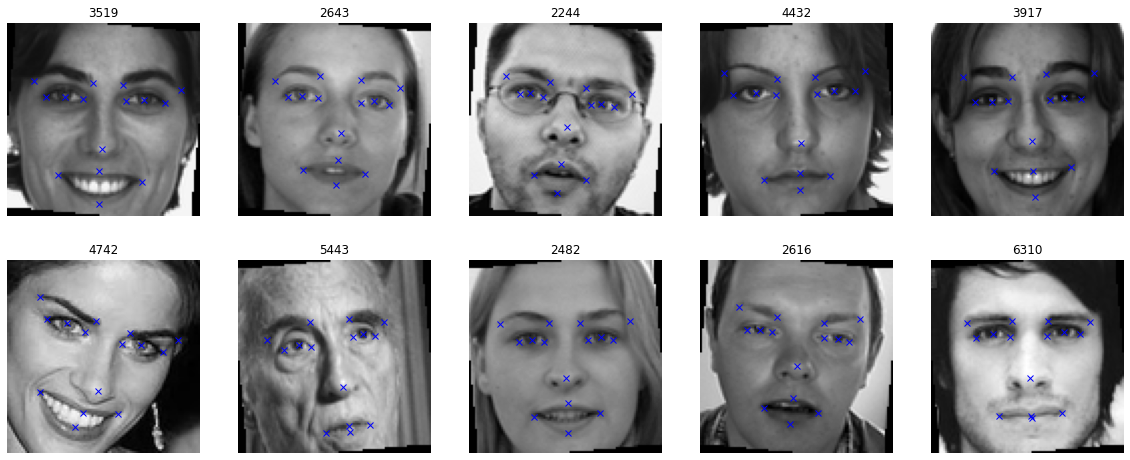

In [152]:
check_n_img(x_rf, n = 10, ncols = 5, figsize = (20, 8), keypoints =  y_rf)

### 표본 평균 얼굴들로 image augmentation

* 일부를 샘플링한 얼굴들의 평균으로 학습시킨다면 도움이 되지 않을까?

* 50개의 랜덤한 얼굴을 평균한 이미지를 2000개 생성

In [153]:
x_avg = []
y_avg = []
for i in range(2000):
    samples = np.random.randint(0, len(y_train_raw), 10)
    y_avg.append(pd.concat([y_train_raw.loc[samples]]).mean(axis = 0))
    x_avg.append(x_train_raw[samples].mean(axis = 0))
x_avg = np.array(x_avg)
y_avg = pd.concat(y_avg, axis = 1).T.reset_index(drop = True)

In [154]:
x_avg.shape, y_avg.shape

((2000, 96, 96, 1), (2000, 30))

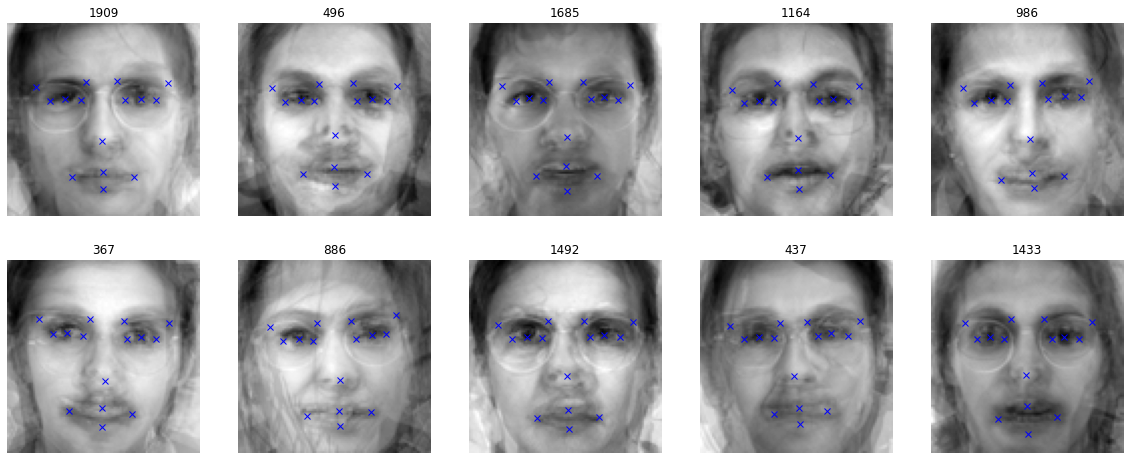

In [155]:
check_n_img(x_avg, n = 10, ncols = 5, figsize = (20, 8), keypoints =  y_avg)

## Train, validation set 나누기

* 원래의 data 중 20%를 validation으로 사용하고, 나머지 80%와 augmented data를 학습에 사용

In [23]:
val_samples = np.random.choice(y_train_raw.index.tolist(), int(len(y_train_raw) * 0.1), replace = False)

In [24]:
y_valid = y_train_raw.loc[val_samples].reset_index(drop = True)
y_train_from_raw = y_train_raw.loc[~y_train_raw.index.isin(val_samples)]

In [25]:
x_valid = x_train_raw[val_samples]
x_train_from_raw = x_train_raw[y_train_from_raw.index]

In [26]:
x_train_from_raw.shape, x_valid.shape, y_train_from_raw.shape, y_valid.shape

((1926, 96, 96, 1), (214, 96, 96, 1), (1926, 30), (214, 30))

* augmented image들을 원래의 이미지 세트와 합치기

In [27]:
x_train = np.append(x_train_from_raw, x_rf, axis = 0)
y_train = pd.concat([y_train_from_raw, y_rf]).reset_index(drop = True)

In [28]:
x_train.shape, y_train.shape

((8346, 96, 96, 1), (8346, 30))